In [1]:
# To enable autcomplete in Jupyter
%config IPCompleter.greedy=True

In [2]:
import datetime # to get current date and time
import pandas as pd
import numpy as np
from numpy.polynomial import polynomial as p
from matplotlib import pyplot as plt
from matplotlib import style as style
from twitterscraper import query_tweets_from_user

%matplotlib inline
style.use('fivethirtyeight')

INFO: {'User-Agent': 'Mozilla/5.0 (Windows; U; Windows NT 6.1; x64; fr; rv:1.9.2.13) Gecko/20101203 Firebird/3.6.13'}


In [3]:
def pullData():
    
    # Raw state csv pulled from New York Times Github
    url1 = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
    state= pd.read_csv(url1)

    # Raw county csv pulled from New York Times Github
    url2 = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
    county = pd.read_csv(url2)
    
    # scrape all tweets from this user
    print("Scraping Twitter for hospitalization data, may take a few moments")
    tweets = query_tweets_from_user("GovMurphy")
    
    '''
    The following lines search for tweets by the query in the quotes. This was used in previous versions of this script but has
    been replaced by searching directly by username.

    # Create Date Objects for start and end of data
    startDate = datetime.date(2020, 4, 8)
    endDate = datetime.date.today() + datetime.timedelta(days=1) # have to use tomorrow's date to include tweets from today
    print(startDate)
    print(endDate)
    limit = 10000 # max number of tweets that will be grabbed
    lang = 'english'
    #username = GovMurphy
    tweets = query_tweets("Phil Murphy", begindate = startDate, enddate = endDate, limit = limit, lang = lang)
    '''
    
    return state, county, tweets

In [4]:
def cleanNYTData(state, county):
    
    # Isolate state data for New Jersey

    # loc isolates data based on labels, save as new dataframe
    nj = state.loc[state['state'] == "New Jersey"]
    
    # Determine days of outbreak
    totalDays = nj.shape[0] # get number of rows containing NJ
    njLength = np.linspace(1,totalDays,totalDays) # create array of same length as total days of data
    njCases = np.array(nj["cases"])
    
    # Get last date of available data
    recentDate = county.at[county.index[-1], 'date']
    
    # Isolate NJ Counties for given date
    njCountyList = county[(county['state'] == "New Jersey") & (county["date"] == recentDate)]
    
    # Create list of the increase in cases between each day and rate of change
    newCases = []

    for i in range(0, len(njCases)-1):
        newCases.append(njCases[i+1]-njCases[i]) # subtract current number of cases by previous number

    newCases = np.array(newCases) # convert case number list to array
    numDaysExceptLast = len(njLength) # need to remove last day from list
    newCaseDays = np.arange(1, numDaysExceptLast) # convert day list to array
    
    # Display Data
    print("Total Cases: " + str(njCases))
    print(njCountyList)
    
    return njLength, njCases, recentDate, njCountyList, newCases, newCaseDays

In [5]:
def cleanTwitterData(tweets):
    
    # convert tweet data to pandas dataframe
    tweetData = pd.DataFrame(t.__dict__ for t in tweets)
    
    # Isolate all tweets from the GovMurphy account
    tweetData = tweetData.loc[tweetData['username'] == "Governor Phil Murphy"]

    # sort from earliest to most recent
    tweetData = tweetData.sort_values(by=['timestamp_epochs']) # timestamp_epochs store number that increases with each tweet

    # reset indices of all dataframe values after sorting
    tweetText = tweetData.reset_index()

    # isolate text from each tweet into a dataframe
    tweetText = tweetText['text']
    
    # generate list of rows from dataframe, tells how many tweets there are to search
    hospDayCount = [i for i in range(tweetData.shape[0])]

    # return hospitalization numbers from all tweets, passing tweet dataframe and range of all tweets
    hospitalized = [hospitalizationExtraction(tweetText,i) for i in hospDayCount]


    # remove none values from invalid tweets
    hospitalized = [i for i in hospitalized if i != None]

    # adjust count to only include valid tweets
    hospDayCount = [i for i in range(1, len(hospitalized)+1)]
    
    print("Total Hospitalized Each Day: " + str(hospitalized))
    
    return hospDayCount, hospitalized

In [6]:
def currentTime():
    
    # Get current date and time
    
    # now method returns date and time
    now = datetime.datetime.now()
    # I returns hour in 12 hour format, p returns AM or PM based on time
    dateAndTime = now.strftime("%m/%d/%Y %I:%M %p")
    
    return dateAndTime

In [7]:
def plotTotalCases(njLength, njCases, recentDate, njCountyList, dateAndTime):
    
    # Create figure object with two subplots oriented horizontally
    figure, (sc, ba) = plt.subplots(1,2, figsize=(21,7))

    # Plot NJ cases vs time
    sc.scatter(njLength, njCases)
    sTitle = "Cases of COVID-19 in New Jersey\n(accurate as of " + recentDate + ")"
    sc.set_title(sTitle)
    sc.set_xlabel("Day of Outbreak")
    sc.set_ylabel("Number of Cases")

    # Fit curve to data 
    coefficients = p.polyfit(njLength, njCases, njLength.shape[0]);
    fit = p.polyval(njLength,coefficients);
    sc.plot(njLength, fit, color='r', linewidth=2);

    # adjust ticks to show all days
    xticks = np.arange(1,njLength.max()+1,4)
    sc.set_xticks(xticks); # semicolon suppresses output of this function

    # Create box label
    labelText = "Current number of cases = " + str(njCases.max())
    box = dict(boxstyle = 'round', facecolor = 'white') # patch options
    sc.text(5, 100000,labelText,bbox=box);

    # Plot cases per county
    ba.bar(njCountyList['county'], njCountyList['cases'] )
    bTitle = "Cases per County\n(accurate as of " + recentDate + ")"
    ba.set_xticklabels(njCountyList['county'], rotation = 90);
    ba.set_title(bTitle);

    print("last updated at: {}".format(dateAndTime))

In [8]:
def plotNewCases(newCases, newCaseDays, recentDate):
    
    # Plot daily increase
    ticks = np.arange(1,newCaseDays.max()+1,5); #generate x ticks
    fig= plt.figure(figsize=(10,4)) # create figure
    axes = fig.add_subplot() # automatically adds axis (graph) in default position
    axes.bar(newCaseDays, newCases.transpose())
    axes.set_title("Daily Increase in Cases in New Jersey and 7-Day Rolling Average Increase\n(accurate as of "
                   + recentDate + ")");
    axes.set_xticks(ticks);
    axes.set_xlabel("Day of Outbreak");
    axes.set_ylabel("Cases");

    '''
    Adding line tracing 7 day rolling average increase in cases

    Because data can be unreliable at any given day, a rolling average allows for 
    visualization of trends over a longer period of time, which is more reliable.

    At each day in the tracker, the mean is taken of the daily increases over the previous 6 days. 
    For days 1-6, there are not 6 days worth of data, so the average is taken with all days up until that point.
    After day 6, the starting variable increases by 1 to trail 6 days behind the current day's data, leaving 7 days in
    between to calculate the average.
    '''
    meanCaseIncrease = []

    sevenDayStart = 0
    for i in range(len(newCases)):
        if i > 6: # trail by 6 days once 6 days of data are available, so average of 7 days can be taken
            sevenDayStart+=1
        # mean of previous 6 days, i+1 to avoid taking mean of empty space after last day of data
        meanCaseIncrease.append(np.mean(newCases[sevenDayStart:i+1])); 

    plt.plot(newCaseDays, meanCaseIncrease, color = 'r');

In [9]:
def plotTrajectory(newCases, newCaseDays):
    
    # Calculate 7 day rolling average and trajectory x axis
    rolling = []
    sevenDayStart = 0
    for i in newCases:
        if i > 6:
            sevenDayStart+=1
        mean = np.mean(newCases[sevenDayStart:i+1])
        if mean > 10:
            rolling.append(mean)
            
    trajectoryDates = np.linspace(1, len(rolling), len(rolling))
      
    # Curve fit of mean cases
    coeff = p.polyfit(trajectoryDates, rolling, newCaseDays.shape[0])
    fit = p.polyval(trajectoryDates, coeff)
    
    # Plot mean new cases in logarithmic scale
    ticks = np.arange(1,trajectoryDates.max()+1, 5); #generate y ticks
    figure = plt.figure()
    traj = figure.add_subplot()
    traj.plot(trajectoryDates, fit)
    traj.set_yticks(ticks)
    traj.set_yscale('log')
    traj.set_xlabel("Days Available")
    traj.set_ylabel("New Cases")
    traj.set_title("Trajectory of Newly Reported Cases (7 Day Rolling Average)")

In [10]:
def hospitalizationExtraction(dataframe, indexOfTweet):

    """
    Parses tweet for the number of hospitalized patients.
    
    Given a dataframe and the index of the tweet in the dataframe, finds where the word 'hospitalized'
    is in that tweet. Then it loops in reverse from that word to the beginning of the tweet until it finds a "word"
    which is a numerical value (the closest number before "hospitalizations" will be the probably be number of 
    hospitalized people, since that is how the sentences are written).
    However, if the first numerical characters are not the correct number, it will keep looking until it finds it.
    It then stores each character of the number in a list, then joins to string, then returns as int
    """
    
    wordsInTweet = dataframe[indexOfTweet].split() # split tweet into list of words
   
    # find index of "hospitalized", trying different splits with punctuation
    
    try:
        hospFound = wordsInTweet.index("hospitalized") # find 'hospitalized'
    except ValueError:
        try: 
            hospFound = wordsInTweet.index("hospitalized.") # find 'hospitalized.''
        except ValueError:
            try: 
                hospFound = wordsInTweet.index("hospitalized,") # find 'hospitalized.' 
            except ValueError:
                try: 
                    hospFound = wordsInTweet.index("hospitals") # find 'hospitals' 
                except:
                    try: 
                        hospFound = wordsInTweet.index("hospitals.") # find 'hospitals.' 
                    except:
                        try:
                            hospFound = wordsInTweet.index("hospitalizations")
                        except:
                            return
    
    # loop from "hospitalizations" to the beginning of the list until the correct number is found

    digits = [] # holds list of all digits in the number 
    for word in range(hospFound,-1,-1): # loop through words (from -1 to include 0) 
        for char in wordsInTweet[word]: 
            if char.isdigit() or char == "0": 
                digits.append(char)
            elif char == ":": # prevents times in XX:XX format or twitter URLs from being included
                digits = []
          
        # if the number has 3 or more digits, it is most likely correct, so break loop
        if len(digits) > 3 and len(digits) < 5: 
            break
        # if the number is 2 digits or less, it is probably wrong so disregard these and continue loop
        else: 
            digits = []
      
    # if the number isn't before the word "hospitalizations" (or others from above), search all words after it
    if len(digits) == 0:
        
        for word in range(hospFound, len(wordsInTweet)): # loop through words (from -1 to include 0) 
            for char in wordsInTweet[word]: 
                if char.isdigit() or char == "0": 
                    digits.append(char)
                elif char == ":" or char.isalpha() : # prevents times in XX:XX format from being included
                    digits = []

            # if the number has 3 or more digits, it is most likely correct, so break loop
            if len(digits) > 3 and len(digits) < 5: 
                break
            # if the number is 2 digits or less, it is probably wrong so disregard these and continue loop
            else: 
                digits = []
     
    number = ""
    try:
        number = int(number.join(digits)) # combine digits into one string and convert to int
        '''
        Unit test:
        print(dataframe[indexOfTweet])
        print("NUMBER RETURNED = " + str(number))
        print("------------------------------------------------------------------------")
        '''
        return number
    except:
        return None # if the tweet is not in the proper format (no valid numbers or otherwise), return none


In [11]:
def plotHospitalizations(hospDayCount, hospitalized):
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.bar(hospDayCount,hospitalized)
    ax.set_title("Total Hospitalized per Day in New Jersey\n(accurate as of {})".format(datetime.date.today()))
    ax.set_ylabel('Hospitalized Individuals')
    ax.set_xlabel('Days Reported')
    ax.set_xticks(hospDayCount);
    ax.text(np.percentile(hospDayCount,25), np.min(hospitalized)-6000,"(Sourced from @GovMurphy on Twitter)"); # place text box at 1st quartile of dates

    def percentChangeHospitalizations(hospitalized):
        # Calculates percentage change in hospitalizations over last 7 days
        mostRecent = len(hospitalized)-1
        totalDecrease = hospitalized[mostRecent] - hospitalized[mostRecent-7]
        pctDecrease = round((totalDecrease / hospitalized[mostRecent-7]) * 100, 2)
        return str(pctDecrease) + "%"

    pct = dict(boxstyle = 'round', facecolor = 'white')
    text = percentChangeHospitalizations(hospitalized) + " change over last 7 days"
    ax.text(8, 6900,text,bbox=pct);


COVID-19 Hospitalizations in New Jersey:<br>Unlike case numbers, there is no direct source for all of the hospitalizations in New Jersey. However, the Governor of New Jersey started reporting hospitalizations almost every day (with some exceptions) from April 9th on his Twitter account, @GovMurphy. While the data from this account is incomplete, it is the only place reporting these values. The following code scrapes Twitter for the governor's tweets relating to hospitalization rates, parses each tweet for the correct number of hospitalizations, and then plots the values.

INFO: Scraping tweets from https://twitter.com/GovMurphy
INFO: Using proxy 47.254.152.23:3128


Scraping Twitter for hospitalization data, may take a few moments


INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/timeline/tweets?include_available_features=1&include_entities=1&max_position=1259893538868822017&reset_error_state=false
INFO: Using proxy 121.170.201.65:80
INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/timeline/tweets?include_available_features=1&include_entities=1&max_position=1259515368953044996&reset_error_state=false
INFO: Using proxy 177.36.188.26:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/timeline/tweets?include_available_features=1&include_entities=1&max_position=1259169718453370880&reset_error_state=false
INFO: Using proxy 200.196.34.103:20183
INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/timeline/tweets?include_available_features=1&include_entities=1&max_position=1258841832928075776&reset_error_state=false
INFO: Using proxy 177.170.20.74:3128
INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/ti

INFO: Using proxy 192.41.71.221:3128
INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/timeline/tweets?include_available_features=1&include_entities=1&max_position=1253021122750296064&reset_error_state=false
INFO: Using proxy 167.71.246.71:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252681309849337858&reset_error_state=false
INFO: Using proxy 51.161.8.214:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252629011848736769&reset_error_state=false
INFO: Using proxy 139.99.91.86:80
INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/timeline/tweets?include_available_features=1&include_entities=1&max_position=1252329390769307655&reset_error_state=false
INFO: Using proxy 188.40.183.191:1080
INFO: Scraping tweets from https://twitter

Total Cases: [     1      2      4      4      6     11     15     23     29     50
     75     98    176    268    427    735    896   1336   1914   2844
   3675   4402   6876   8825  11124  13386  16636  18696  22255  25590
  29895  34124  37505  41090  44416  47437  51027  54588  58151  61850
  64584  68824  71030  75317  78467  81420  85301  88806  92387  95865
  99989 102196 105523 109038 111188 113856 116264 118652 121190 123717
 126744 128269 130593 131890 133635 135454 137085 138532]
              date      county       state     fips  cases  deaths
131384  2020-05-10    Atlantic  New Jersey  34001.0   1510      72
131385  2020-05-10      Bergen  New Jersey  34003.0  16929    1355
131386  2020-05-10  Burlington  New Jersey  34005.0   3574     198
131387  2020-05-10      Camden  New Jersey  34007.0   4870     225
131388  2020-05-10    Cape May  New Jersey  34009.0    458      32
131389  2020-05-10  Cumberland  New Jersey  34011.0   1287      36
131390  2020-05-10       Essex  Ne

C:\Users\jayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RankWarning: The fit may be poorly conditioned
  app.launch_new_instance()


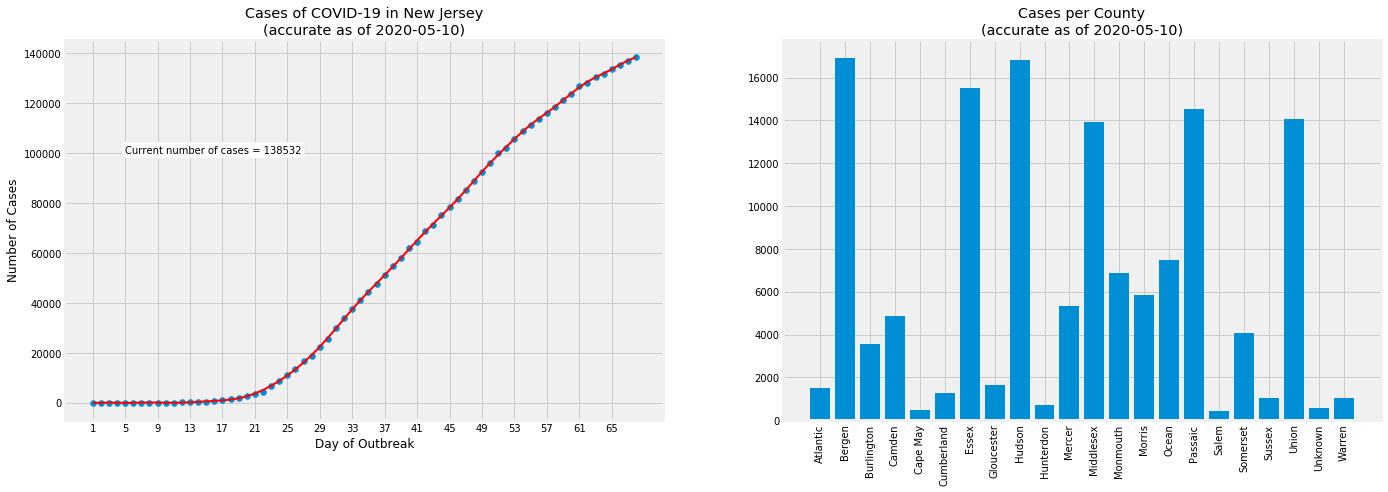

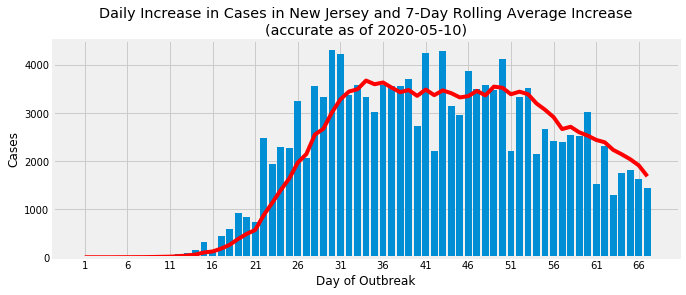

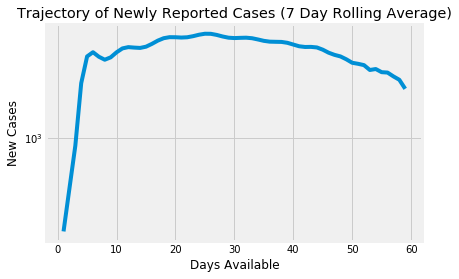

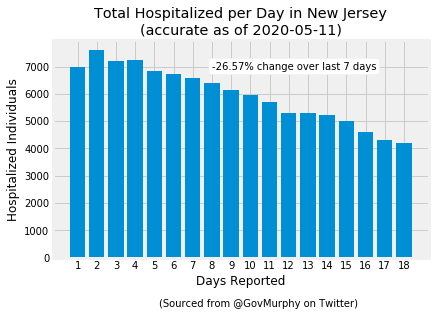

In [12]:
def main():
    dateAndTime = currentTime()
    [state, county, tweets] = pullData()
    [njLength, njCases, recentDate, njCountyList, newCases, newCaseDays] = cleanNYTData(state, county)
    [hospDayCount, hospitalized] = cleanTwitterData(tweets)
    plotTotalCases(njLength, njCases, recentDate, njCountyList, dateAndTime)
    plotNewCases(newCases, newCaseDays, recentDate)
    plotTrajectory(newCases, newCaseDays)
    plotHospitalizations(hospDayCount, hospitalized)
    
if __name__ == "__main__":
    main()